In [2]:
import numpy as np 
import pandas as pd 
import torch
from tqdm.notebook import tqdm
import random

initial settings

In [24]:
n_sample = 5000
n_epoch = 4
lr_rate = 1e-5

Read Data

In [4]:
url = 'https://git.uwaterloo.ca/ky5liu/680-project/-/raw/main/training.1600000.processed.noemoticon.csv'
columns = ["target", "ids", "date", "flag", "user", "Text"]
df = pd.read_csv(url, encoding = "ISO-8859-1", names=columns)

## Sample Size

Set sample size to 5000 or any other numbers

In [5]:
random.seed(680)
df = df.sample(n = n_sample, replace = False)

In [6]:
df.set_index('ids',inplace = True)

Give emotion a label where 0 is sad, 4 is happy

In [7]:
possible_label = df.target.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{4: 0, 0: 1}

New column of label to represent emotion

In [8]:
df["Label"] = df["target"].replace(dict_label)

Drop columns that are not useful


In [9]:
df=df.drop(columns=["target", "date", "flag", "user"], axis = 1)
df.head()


,Text,Label
ids,,
2189536639,@willcritchlow thanks for your help on SEOmoz ...,0
2323078237,Eating pik-nik. It's makes me feel like a litt...,1
2002648324,aaah my mum is the best one,0
1974333009,@forman_ Wtf you noob GTFO!,0
1966321801,...and nothing feels better alphabetizing and ...,0


##Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.index.values,
                                                df.Label.values,
                                                test_size = 0.2,
                                                random_state=680,
                                                stratify = df.Label.values)

Give new column name to dataset

In [11]:
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'

Modeling

In [12]:
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 34.9 MB/s 
     |████████████████████████████████| 7.6 MB 69.4 MB/s 
     |████████████████████████████████| 182 kB 78.1 MB/s 


BERT tokenizer
- Edit this for other tokenzier options
https://huggingface.co/docs/transformers/main_classes/tokenizer#:~:text=%E2%80%9CFast%E2%80%9D%20implementation

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)
tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

https://huggingface.co/docs/transformers/v4.24.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus

In [14]:
%%time
encoder_train = tokenizer.batch_encode_plus(df[df["data_type"]=='train'].Text.values,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(df[df["data_type"]=='test'].Text.values,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
#List of indices specifying which tokens should be attended to by the model 
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(df[df['data_type']=='train'].Label.values)
# df[df['data_type']=='train'].Label.value_counts()

input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(df[df['data_type']=='test'].Label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


CPU times: user 2.66 s, sys: 17.5 ms, total: 2.68 s
Wall time: 3.01 s


In [15]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

Functions for model performance

In [16]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')


###############################################

def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")
###############################################

def acc_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat,preds_flat)

In [17]:
seed_val = 680
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Model

## Batch size


Load data from encoded data

- tuning batch size, higher requires gpu, but faster
  - 16, 32 originally
  - 1000,1000 out of memory

In [18]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

In [19]:

from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Epoch and Optimizer

In [25]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = lr_rate, eps = 1e-8)

epochs  = n_epoch
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using GPU


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


Predict Function

In [22]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

Cross entropy loss is used for loss since we have a binary classification problem

https://stackoverflow.com/questions/71581197/what-is-the-loss-function-used-in-trainer-from-the-transformers-library-of-huggi

In [26]:
%%time
accuracy_lis = []
training_loss = []
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}\f Train Accuracy')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    test_acc = acc_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test F1 Score:{test_score}\n Test Accuracy:{test_acc}')
    accuracy_lis.append(test_acc)
    training_loss.append(loss_train_avg)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/250 [00:00<?, ?it/s]

<timed exec>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.4512015379071236 Train Accuracy


  0%|          | 0/32 [00:00<?, ?it/s]

Val Loss:0.43768798653036356
 Test F1 Score:0.7867396434717407
 Test Accuracy:0.787


Epoch: 2:   0%|          | 0/250 [00:00<?, ?it/s]

<timed exec>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.3308998641371727 Train Accuracy


  0%|          | 0/32 [00:00<?, ?it/s]

Val Loss:0.48483682284131646
 Test F1 Score:0.7945506727758502
 Test Accuracy:0.796


Epoch: 3:   0%|          | 0/250 [00:00<?, ?it/s]

<timed exec>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.23911827966570853 Train Accuracy


  0%|          | 0/32 [00:00<?, ?it/s]

Val Loss:0.5184844525065273
 Test F1 Score:0.8077516489061354
 Test Accuracy:0.808


Epoch: 4:   0%|          | 0/250 [00:00<?, ?it/s]

<timed exec>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.19208605585992336 Train Accuracy


  0%|          | 0/32 [00:00<?, ?it/s]

Val Loss:0.5603485917672515
 Test F1 Score:0.8059231387991788
 Test Accuracy:0.806
CPU times: user 11min 50s, sys: 4.11 s, total: 11min 55s
Wall time: 11min 54s


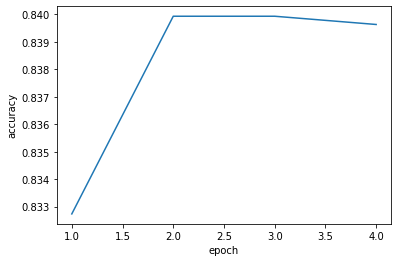

In [ ]:
from matplotlib import pyplot
pyplot.plot([1,2,3,4],accuracy_lis)
pyplot.xlabel("epoch")
pyplot.ylabel("accuracy")
pyplot.show()

In [ ]:
pyplot.savefig('bert_epoch_accuracy.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
#training_loss = [0.4200256376057863, 0.3079329135142267, 0.2325340534660965, 0.1843095047879964]

# New Section

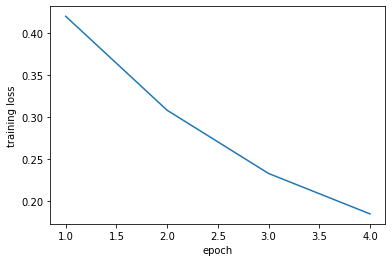

In [ ]:
pyplot.plot([1,2,3,4],training_loss)
pyplot.xlabel("epoch")
pyplot.ylabel("training loss")
pyplot.show()

In [ ]:
pyplot.savefig('bert_epoch_loss.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
val_loss,predictions,true_vals = evaluate(dataloader_test)

predictions
np.argmax(predictions,axis=1).flatten()
labels_flat = true_vals.flatten()
labels_flat


  0%|          | 0/313 [00:00<?, ?it/s]

array([0, 0, 1, ..., 1, 1, 0])